In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V2 import *
import aux_func_numpy as debug

In [2]:
# Criando o conjunto de dados que será utilizado para o treino da rede neural

#------------------------------------------------------------------------------
# U_full = Gera_dados() # Gerando os dados

# # Utilizando a CPU como processador
# with tf.device('/device:CPU:0'):
#     data_full = tf.transpose(tf.concat(U_full, axis=0)) # Formatando os dados
#-------------------------------------------------------------------------------

"\nU_full=Gera_dados()\nwith tf.device('/device:CPU:0'):\n    data_full=tf.transpose(tf.concat(U_full,axis=0))\n"

In [3]:
# Salvando o conjunto de dados que será utilizado para o treino da rede neural

#--------------------------------------------------
# # Importando o pacote de manipulação de arquivos
# import dill

# # Salvando os dados
# with open('data.bck','wb') as file:
#     dill.dump(data_full, file)
#--------------------------------------------------

"\nimport dill\n\nwith open('data.bck','wb') as file:\n    dill.dump(data_full,file)\n"

In [4]:
# Lendo o conjunto de dados que será utilizado para o treino da rede neural

# Importando o pacote de manipulação de arquivos
import dill

# Lendo os dados
with open('data.bck','rb') as file:
    # Utilizando a CPU como processador
    with tf.device('/device:CPU:0'):
        data_full = dill.load(file)
        data_full = tf.transpose(data_full[0],[1,0,2]).numpy()

In [5]:
# Formatando conjunto de dados para o treino da rede neural
data_x = np.squeeze(data_full[:,:,:-1])
data_y = np.squeeze(data_full[:,:,1:])

data_x = data_x[:,np.arange(100)*4]
data_y = data_y[:,np.arange(100)*4]
data_x = np.concatenate(np.split(data_x, data_x.shape[2], axis=2), axis=0)
data_y = np.concatenate(np.split(data_y, data_y.shape[2], axis=2), axis=0)

indices = np.where(np.sum(data_x**2, axis=1) > 0)[0]
data_x  = data_x[indices]
data_y  = data_y[indices]

# Aleatorizando a ordem dos elementos dos dados
indice = np.arange(data_x.shape[0])
np.random.shuffle(indice)
data_x = data_x.astype('float64')[indice]
data_y = data_y.astype('float64')[indice]

In [6]:
# Conjunto de dados de treino
train_x = data_x[:-20000]
train_y = data_y[:-20000]

# Conjunto de dados de validação
test_x = data_x[-20000:]
test_y = data_y[-20000:]

In [7]:
# Função que define a taxa de aprendizagem para diferentes
# iterações de treino, a ideia é começar com uma taxa grande e 
# diminuir ao longo do treino para "refinar" a aprendizagem da rede

def scheduler(epoch, lr):
    if epoch < 1:
        return 10**-2
    elif epoch<2:
        return 10**-3
    else:
        return 10**-4
    
# Passando para o keras a função scheduler
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [8]:
class Burguers_layer(keras.layers.Layer):
    """Criando uma camada de rede neural cuja superclasse é a camada
    do keras para integrar o algoritmo do WENO com a rede neural"""
    
    def __init__(self, t_final, Δx, CFL, fronteira):
        """
        Construtor da classe
        --------------------------------------------------------------------------------------
        t_final      (float): tamanho máximo da variação temporal
        Δx           (float): distância espacial dos pontos na malha utilizada
        CFL          (float): constante utilizada para determinar o tamanho da malha temporal
        fronteira (function): função que determina o comportamento do algoritmo na fronteira
        --------------------------------------------------------------------------------------
        """
        super(Burguers_layer, self).__init__(dtype='float64') # Chamando o inicializador da superclasse
        
        # Salvando os valores dos parâmetros do construtor no objeto
        self.t_final   = tf.cast(t_final, 'float64')
        self.Δx        = Δx
        self.CFL       = CFL
        self.fronteira = fronteira
        
    def build(self, input_shape):
        """
        Função para compor as camadas que constituem essa camada da rede neural
        ------------------------------------------------------------------------
        input_shape : não é utilizado por essa função, mas é um argumento obrigatório para camadas do Keras.
        ------------------------------------------------------------------------
        """
        self.layers = []
        wei_reg = tf.keras.regularizers.L2(0*10**-3)                                                                        # Regularização dos pesos da rede 
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                        # Camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(5, 5, activation='elu',     dtype=data_x.dtype, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        self.layers.append(tf.keras.layers.ZeroPadding1D(padding=2))                                                        # Camada de padding de zeros em 1 dimensão
        self.layers.append(keras.layers.Conv1D(3, 5, activation='elu',     dtype=data_x.dtype, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        self.layers.append(keras.layers.Conv1D(1, 1, activation='sigmoid', dtype=data_x.dtype, kernel_regularizer=wei_reg)) # Camada de convolução em 1 dimensão
        
    def network_graph(self, x):
        """
        Função utilizado para executar sucessivamente as camadas dessa camada 
        da rede neural, passando o input de uma para a próxima
        ----------------------------------------------------------------------
        x (tensor): valor de entrada da rede
        ----------------------------------------------------------------------
        y (tensor): valor de saída da rede
        ----------------------------------------------------------------------
        """
        y = x # Valor de entrada
        
        # Percorrendo as camadas
        for layer in self.layers:
            
            # Atualizando o valor de entrada para a próxima camada
            y = layer(y) 
            
        return y
        
    def call(self, inpt, mask=None):
        """
        Função utilizada para treino que recebe o input da camada e computa o output
        -----------------------------------------------------------------------------
        inpt  (tensor): input passado para a camada
        mask       (?): não é utilizado por essa função
        -----------------------------------------------------------------------------
        outpt (tensor): output retorna pela camada
        -----------------------------------------------------------------------------
        """
        Λ  = tf.math.reduce_max(tf.abs(inpt)) # Valor utilizado para obter o Δt
        Δt = self.Δx*self.CFL/Λ               # Obtendo o valor de Δt a partir de CFL
        
        # Caso o passo temporal utrapasse o valor de t_final
        # então o tamanho do passo se torna o tempo que 
        # falta para se obter o t_final
        Δt = tf.where(Δt > self.t_final, self.t_final, Δt)
        
        outpt = Graph_Burgers(u=inpt, Δt=Δt, Δx=self.Δx, fronteira=self.fronteira, network=self.network_graph)
        return outpt
    
    def predict(self, inputs, mask=None):
        """Função que faz previsão a partir de um input"""
        return self(inputs, mask=None) # Chamando o função call (self.predict(inputs, mask) = self.call(inpt, mask))

In [9]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([100,1], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-4, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando uma camada de Burgers que integra o WENO à rede neural
final_layer = Burguers_layer(t_final=0.01, Δx=0.01, CFL=0.5, fronteira=FronteiraPeriodica)

class MES_OF(tf.keras.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    
    def call(self, y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        --------------------------------------------------------------------------
        """
        y_true = tf.cast(y_true, y_pred.dtype) # Convertendo os tipos para evitar conflitos
        y_min  = tf.math.reduce_min(y_true,axis=1,keepdims=True)
        y_max  = tf.math.reduce_max(y_true,axis=1,keepdims=True)
        
        loss = tf.reduce_mean(
            tf.math.square(y_pred - y_true), axis=-1) + \        # Custo por erro na norma L2
            tf.reduce_sum(
                tf.where(y_pred > y_max, y_pred - y_max,  0) + \ # Custo por previsão 'muito alta'
                tf.where(y_pred < y_min, y_min  - y_pred, 0),    # Custo por previsão 'muito baixa'
            axis=-1)
        
        return 

# Criando a rede neural
Network = keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss=MES_OF(), optimizer=optimizer, metrics=['mean_absolute_error'])
# Carregando os pesos da rede neural treinados
Network.load_weights('Modelo artigo')

In [ ]:
# Treinando a rede neural
Network.fit(
    train_x                           , # Dados de treino
    train_y                           , # Dados de treino
    validation_data = (test_x, test_y), # Dados de validação
    batch_size      = 1024            , # Tamanho do batch
    epochs          = 100             , # Número de epochs
    steps_per_epoch = 300             , # Número de batchs por epoch
    shuffle         = True              # Aleatorização dos batchs
)

# Batch: pacote de dados utilizados antes de uma atualização dos pesos da rede
# Epoch: rodada de treino da rede neural, em geral percorre todo o conjunto de dados

In [15]:
# Salvando os pesos treinados
Network.save_weights('Modelo artigo')

In [10]:
# Carregando os pesos treinados
Network.load_weights('Modelo artigo')

In [11]:
# Calculando os erros de previsão utilizando o WENO-Z em uma malha mais fina 
# como solução de referência e depois calculando o WENO-Z e o WENO-Z com a 
# modificação da rede neural numa malha mais grossa

Δx = 0.04                                  # Distância espacial dos pontos na malha mais grossa utilizada
x  = tf.range(-2, 2, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

full_U   = test_x[-20000:] # 20000 últimos dados de entrada do conjunto de treino
ref_full = test_y[-20000:] # 20000 últimos dados de saída do conjunto de treino

CFL    = 0.5  # Constante utilizada para determinar o tamanho da malha temporal
Δt_max = 0.01 # Instante de tempo final
t      = 0.0  # Instante de tempo inicial

# Valor utilizado para obter o Δt
Λ = tf.math.reduce_max(tf.abs(full_U), axis=1, keepdims=True)
# Obtendo o valor de Δt a partir de CFL
Δt = Δx*CFL/Λ
# Caso o passo temporal utrapasse o valor de Δt_max então o 
# tamanho do passo se torna Δt_max
Δt = tf.where(Δt > Δt_max, Δt_max, Δt)

net_u   = tf.squeeze(Network.predict(full_U))             # Previsão com o WENO-Z modificado pela rede neural
debug_u = Burgers(full_U,Δt, Δx, CFL, FronteiraPeriodica) # Previsão com o WENO-Z

# Armazenando ambos os erros de previsão
error = tf.stack([tf.squeeze(net_u)-tf.squeeze(ref_full),tf.squeeze(tf.squeeze(debug_u)-tf.squeeze(ref_full))],axis=0)

In [12]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(tf.math.reduce_mean(error**2, axis=1)**0.5, axis=1)
#--------------------------------------------------------------------------------------

# Norma L1:
#--------------------------------------------------------------------------------------
# desv_error = tf.math.reduce_mean(tf.math.reduce_mean(tf.abs(error), axis=1), axis=1)
#--------------------------------------------------------------------------------------

# Noma L-inf:
#-------------------------------------------------------------------------------------
# desv_error = tf.math.reduce_mean(tf.math.reduce_max(tf.abs(error), axis=1), axis=1)
#-------------------------------------------------------------------------------------

# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

[0.0265176  0.03306171]
0.8020639284746661


In [13]:
# Calulando o erro na norma L2 para cada entrada
desv_error = tf.math.reduce_mean(error**2, axis=1)**0.5

# Obtendo os índices dos erros que não são 'extremos'
valid = (desv_error[0].numpy()/desv_error[1].numpy()) < 10

# Observando a razão dos erros considerando os índices dos não 'extremos'
np.mean((desv_error[0].numpy()/desv_error[1].numpy())[valid])

0.7948787024834919

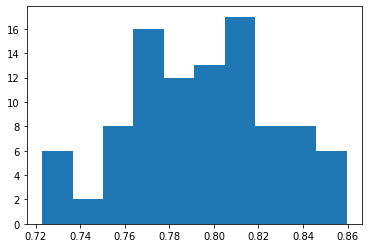

In [14]:
# Histograma da razão (rede neural/WENO-Z)
plt.hist((desv_error[0].numpy()/desv_error[1].numpy())[valid])
plt.show()

In [135]:
# Valor inicial para func_ref
init = tf.zeros([1,5,1], dtype='float64')
init = tf.random.normal([1,5,1], 0, 1, dtype='float64')
# ???
func_ref = tf.Variable(init, trainable=True)
# Valor alvo dos indicadores de suavidade locais
target   = tf.constant([[[0],[1],[1]]], dtype='float64')
# target = target/tf.math.reduce_sum(target)

In [136]:
# Não entendi direito o que essa parte do código está fazendo exatemente;
# acredito que aqui está sendo definida uma nova função de perda e estão
# sendo escolhidos os subestêncis que maximizam algum valor específico de
# saída da rede neural

learnrate = tf.Variable(10**-2,dtype='float64')

@tf.function
def step():
    with tf.GradientTape(persistent=False) as watch_grad:
        pred  = Network.layers[1].network_graph(func_ref)
        pred  = pred/tf.math.reduce_sum(pred)
        error = (pred-target)**2/2
        
    grad = watch_grad.gradient(error, func_ref) # Magia do tensorflow para calcular o gradiente
    func_ref.assign(func_ref-learnrate*grad)    # Treinando via gradiente descendente
    
@tf.function
def step_weight():
    with tf.GradientTape(persistent=False) as watch_grad:
        
        ɛ = 10.0**(-40)
        U = func_ref # Seleciona o subestêncil
        
        # Calculando o input para a rede neural
        # Entrada 1: U_{i+1} - U_{i-1}
        # Entrada 2: U_{i+1} - 2*U_{i} + U_{i-1}
        U_diff      = tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]], axis=2)
        # Obtendo os modificadores dos pesos executando a rede neural
        beta_weight = tf.transpose(Network.layers[1].network_graph(U_diff), [0,2,1])
        
        # Calcula os indicadores de suavidade locais
        u = tf.transpose(tf.stack([func_ref,func_ref,func_ref], axis=0), [0,1,3,2])

        β = tf.math.reduce_sum(u * (u @ A), axis=3)
        β = tf.transpose(β, [1,2,0])
        β = β*(beta_weight+0.01) # Modificação da rede neural
        
        # Calcula o indicador de suavidade global
        τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])
        
        # Calcula os pesos do WENO modificado pelo rede neural
        α    = (1 + (τ/(β + ɛ))**2) @ B
        soma = tf.math.reduce_sum(α, axis=2, keepdims=True)
        ω    = α / soma

        # Renomeado os pesos
        pred = ω
        
        # Calculando o erro de previsão pela norma L2
        error2 = tf.math.reduce_mean((target-pred)**2)
        # Calculando o erro de previsão por... (Divergência de Kullback-leibler?)
        error  = -tf.math.reduce_sum(target*tf.math.log(pred)+(1-target)*tf.math.log(1-pred))
    
    grad = watch_grad.gradient(error, func_ref) # Magia do tensorflow para calcular o gradiente
    func_ref.assign(func_ref-learnrate*grad)    # Treinando via gradiente descendente
    
    return error2 # tf.math.reduce_max(tf.abs(grad))

@tf.function
def step_filter():
    with tf.GradientTape(persistent=False) as watch_grad:
        
        ɛ = 10.0**(-40) # Inútil?
        
        U      = func_ref
        U_diff = tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]], axis=2)
        obj    = U_diff
        
        for layer in Network.layers[1].layers[:5]:
            obj = layer(obj)
            
        error = tf.math.reduce_sum((obj-target)**2)

    grad = watch_grad.gradient(error, func_ref) # Magia do tensorflow para calcular o gradiente
    func_ref.assign(func_ref-learnrate*grad)    # Treinando via gradiente descendente
    
    return error # tf.math.reduce_max(tf.abs(grad))

In [137]:
# Definindo o tamanho do passo de treino
learnrate.assign(10**-1)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=0.1>

In [138]:
# 'Treinando' para obter o substêncil que maxima as características desejadas

error = 10
count = 0
while error > 10**-2: # max_grad>10**-4:
    count += 1
    error  = step_filter()
    if count % 1000==0:
        # count = 0
        print(error.numpy())

In [139]:
# Calculando o WENO-Z com a modificação da rede neural utilizando
# o subestêncil encontrado

ɛ = 10.0**(-40)
U = func_ref # Seleciona o subestêncil

# Calculando o input para a rede neural
# Entrada 1: U_{i+1} - U_{i-1}
# Entrada 2: U_{i+1} - 2*U_{i} + U_{i-1}
U_diff      = tf.concat([U[:,2:]-U[:,:-2],U[:,2:]-2*U[:,1:-1]+U[:,:-2]], axis=2)
# Obtendo os modificadores dos pesos executando a rede neural
beta_weight = tf.transpose(Network.layers[1].network_graph(U_diff), [0,2,1])

print('Rede: ', beta_weight.numpy()) # Printando o resultado

# Calcula os indicadores de suavidade locais
u = tf.transpose(tf.stack([func_ref,func_ref,func_ref], axis=0), [0,1,3,2])
    
β = tf.math.reduce_sum(u * (u @ A), axis=3)
β = tf.transpose(β, [1,2,0])
print('Beta pre:   ', tf.squeeze(β).numpy()) # Printando o resultado
β = β*(beta_weight+0.01)                     # Modificação da rede neural
print('Beta final: ', tf.squeeze(β).numpy()) # Printando o resultado

# Calcula o indicador de suavidade global
τ = tf.abs(β[:,:,0:1] - β[:,:,2:3])

# Calcula os pesos do WENO modificado pelo rede neural
α    = (1 + (τ/(β + ɛ))**2) @ B
soma = tf.math.reduce_sum(α, axis=2, keepdims=True)
ω    = α / soma
print('Omega:      ',tf.squeeze(ω).numpy()) # Printando o resultado

Rede:  [[[0.006615   0.92993874 0.92972346]]]
Beta pre:    [2.41148778 9.81887189 4.21440976]
Beta final:  [0.04006687 9.22913808 3.96037972]
Alpha:       [9.98641754e-01 7.38731935e-04 6.19514383e-04]


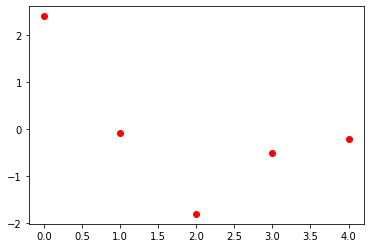

In [140]:
# Plotando o resultado obtido

#plt.ylim((np.min(train_x), np.max(train_x)))
plt.plot(np.squeeze(func_ref.numpy()),'ro')

In [48]:
init=tf.constant([[[0],[0],[0],[0],[-1]]],dtype='float64')

In [49]:
Network.layers[1].network_graph(init)

ValueError: Input 0 of layer conv1d is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (1, 9, 1)

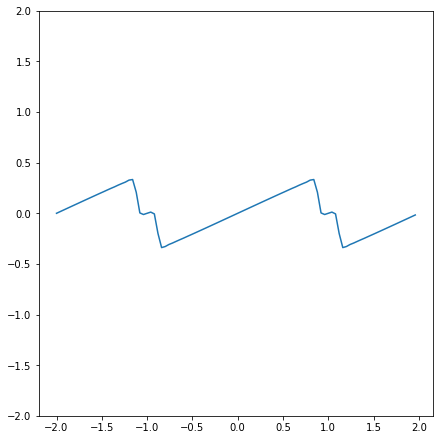

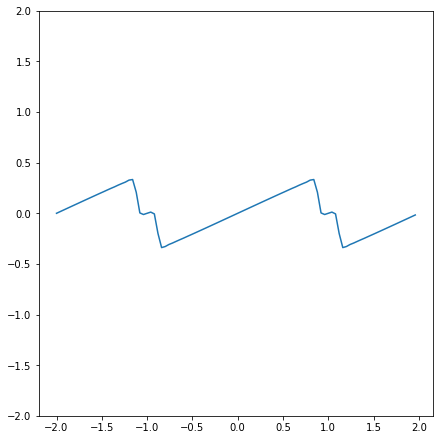

In [27]:
# Visualizando o ajuste do WENO-Z com a modificação da rede neural

Δx = 0.04                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-2, 2, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

# Gerando uma condição inicial aleatória
#------------------------------------------------------------------------------------------------------------------
k1 = tf.random.uniform([1], 0, 20, dtype='int32')   # Amostrando uma frequência aleatória para a função seno
k1 = tf.cast(k1, dtype=float_pres)                  # Mudando o tipo do tensor
k2 = tf.random.uniform([1], 0, 20, dtype='int32')   # Amostrando uma frequência aleatória para a função seno
k2 = tf.cast(k2, dtype=float_pres)                  # Mudando o tipo do tensor
a  = tf.random.uniform([1], 0, 1, dtype=float_pres) # Amostrando um peso aleatória para ponderar as funções seno
b  = tf.random.uniform([1], 0, 2, dtype=float_pres) # Amostrando um modificador de amplitude aleatório
#------------------------------------------------------------------------------------------------------------------

# Fixando a condição inicial
#-----------------------------------------------
# k1 = 1.0 # Frequência para a função seno
# k2 = 2.0 # Frequência para a função seno
# a  = 0.5 # Peso para ponderar as funções seno
# b  = 0.5 # Modificador de amplitude
#-----------------------------------------------


u1 =     a * tf.expand_dims(tf.math.sin(k1*pi*x),axis=1) # Gerando pontos de acordo com a primeira função seno
u2 = (1-a) * tf.expand_dims(tf.math.sin(k2*pi*x),axis=1) # Gerando pontos de acordo com a segunda função seno

u = b*(u1+u2)                 # Obtendo a condição inicial a partir das funções senos
u = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão

CFL = 0.5                          # Constante utilizada para determinar o tamanho da malha temporal
Δt  = 0.01                         # Δt entre cada frame de animação
T   = tf.range(0.0, 2.0, Δt)       # Frames da animação
T   = tf.cast(T, dtype=float_pres) # Mudando o tipo do tensor

t = 0.0 # Instante de tempo inicial


# Gerando os gráficos a partir de funções do matplotlib

fig = plt.figure(1, constrained_layout=True,figsize=(6,6))
ax = fig.add_subplot(1,1,1);
ax.set_ylim(-2, 2);
#ax.set_xlim(0,1);
line=ax.plot(x,tf.squeeze(u))
hfig = display(fig, display_id=True)
Δt_list=tf.zeros([0],dtype=float_pres)


while t < T[-1]:
    
    # Executando o WENO-Z modificado pela rede neural
    u = Network.predict(u)
    
    # Removendo dimensões desnecessárias
    squeezed_u=tf.squeeze(u)
    
    # Avançando no tempo
    t += Δt

    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u.numpy())
    fig.canvas.draw()
    hfig.update(fig)

In [142]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200,1], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-4, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando uma camada de Burgers que integra o WENO à rede neural
final_layer = Burguers_layer(t_final=0.1, Δx=0.01, CFL=0.5, fronteira=FronteiraPeriodica)

class MES_OF(tf.keras.losses.Loss):
    """Criando uma função de custo cuja superclasse é a de funções de
    custo do keras"""
    
    def call(self, y_true, y_pred):
        """
        Função que avalia o custo dado um valor de referência e um valor previsto
        --------------------------------------------------------------------------
        y_true (tensor): valor de referência
        y_pred (tensor): valor predito
        --------------------------------------------------------------------------
        loss   (tensor): custo associado
        --------------------------------------------------------------------------
        """
        y_true = tf.cast(y_true, y_pred.dtype)
        y_min  = tf.math.reduce_min(y_true, axis=1, keepdims=True)
        y_max  = tf.math.reduce_max(y_true, axis=1, keepdims=True)
        
        loss = tf.reduce_mean(
            tf.math.square(y_pred - y_true), axis=-1) + \        # Custo por erro na norma L2
            tf.reduce_sum(
                tf.where(y_pred > y_max, y_pred - y_max,  0) + \ # Custo por previsão 'muito alta'
                tf.where(y_pred < y_min, y_min  - y_pred, 0),    # Custo por previsão 'muito baixa'
            axis=-1)
        
        return loss

# Criando a rede neural
Network = keras.Model(input_x, final_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss=MES_OF(), optimizer=optimizer, metrics=['mean_absolute_error'])
# Carregando os pesos da rede neural treinados
Network.load_weights('Modelo artigo')

In [1]:
# Visualizando os resultados

Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional


# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

u = f_test(x) # Obtendo a condição inicial a partir de f_test
#-------------------------------------------------------------------------------------------

# Gerando uma condição inicial aleatória
#------------------------------------------------------------------------------------------------------------------
# k1 = tf.random.uniform([1], 0, 20, dtype='int32')   # Amostrando uma frequência aleatória para a função seno
# k1 = tf.cast(k1, dtype=float_pres)                  # Mudando o tipo do tensor
# k2 = tf.random.uniform([1], 0, 20, dtype='int32')   # Amostrando uma frequência aleatória para a função seno
# k2 = tf.cast(k2, dtype=float_pres)                  # Mudando o tipo do tensor
# a  = tf.random.uniform([1], 0, 1, dtype=float_pres) # Amostrando um peso aleatória para ponderar as funções seno
# b  = tf.random.uniform([1], 0, 2, dtype=float_pres) # Amostrando um modificador de amplitude aleatório

# # Função que gera pontos de acordo com a primeira função seno
# u1 =     a * tf.expand_dims(tf.math.sin(k1*pi*x), axis=1)
# # Função que gera pontos de acordo com a segunda função seno
# u2 = (1-a) * tf.expand_dims(tf.math.sin(k2*pi*x), axis=1)
# # Obtendo a condição inicial a partir das funções senos
# u = b*(u1+u2)
#------------------------------------------------------------------------------------------------------------------

# Condição inicial fixada
#----------------------------------------------------------------------
# k1 = 5    # Frequência para a função seno
# k2 = 2    # Frequência para a função seno
# a  = 0.25 # Peso para ponderar as funções seno
# b  = 0.75 # Modificador de amplitude

# # Função que gera pontos de acordo com a primeira função seno
# u1 = lambda x:     a * tf.expand_dims(tf.math.sin(k1*pi*x), axis=1)
# # Função que gera pontos de acordo com a segunda função seno
# u2 = lambda x: (1-a) * tf.expand_dims(tf.math.sin(k2*pi*x), axis=1)
# # Obtendo a condição inicial a partir das funções senos
# u  = b*(u1(x)+u2(x))
#-----------------------------------------------------------------------

u = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão

CFL = 0.5                          # Constante utilizada para determinar o tamanho da malha temporal
Δt  = 0.1                          # Δt entre cada frame de animação
T   = tf.range(0.0, 2.0, Δt)       # Frames da animação
T   = tf.cast(T, dtype=float_pres) # Mudando o tipo do tensor

t = 0.0 # Instante de tempo inicial


# Gerando os gráficos a partir de funções do matplotlib

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
#ax.set_xlim(0,1)
line = ax.plot(x, tf.squeeze(u))
hfig = display(fig, display_id=True)
Δt_list = tf.zeros([0], dtype=float_pres)


while t < T[-1]:
    
    # Executando o WENO-Z modificado pela rede neural
    u = Network.predict(u)
    
    # Removendo dimensões desnecessárias
    squeezed_u=tf.squeeze(u)
    
    # Avançando no tempo
    t += Δt

    # Exibindo graficamente os valores obtidos
    line[0].set_ydata(squeezed_u.numpy())
    fig.canvas.draw()
    hfig.update(fig)

NameError: name 'tf' is not defined